In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [2]:
raw_data      = pd.read_csv('../data/sentence-relations/train.csv', index_col='id')
raw_submissions = pd.read_csv('../data/sentence-relations/test.csv', index_col='id')

# Drop chinese and thai
raw_data = raw_data[raw_data['lang_abv'] != 'zh']
raw_data = raw_data[raw_data['lang_abv'] != 'th']

training_data, test_data = train_test_split(raw_data, test_size=0.2, random_state=42)

training_data.head()

,premise,hypothesis,lang_abv,language,label
id,,,,,
2ae1ae603b,The experiment lasted only until Ahkenaten's d...,The experiment ended with Ahkenaten's death.,en,English,0
bd9cf13289,"200.000 alfaz ki novel $25 kai hisab se 8,000 ...",ایک 200000 الفاظ والے ناول جو 25 ڈالر کا ہو اس...,ur,Urdu,2
a359a01670,Σας ευχαριστούμε που υποστηρίξατε το Μουσείο Τ...,Είμαστε πολύ χαρούμενοι που βοηθήσατε να στηρί...,el,Greek,0
5b2bc22ef1,Two more weeks with my cute TV satellite dish...,My appreciation of my satellite dish has incre...,en,English,0
f745ec0224,"They are built on the site of David's Tower, o...",The structures are on the site of David's Tower.,en,English,0


In [3]:
from transformers import AutoModelForSequenceClassification, BertTokenizer, RobertaTokenizer
from transformers import pipeline

MODEL_MAPPING = {
    'bert-finetuned': 'bert-checkpoint-374-finetuned',
    'bert-retrained': 'bert-checkpoint-2752',
    'roberta-finetuned': 'roberta-checkpoint-4816-finetuned',
    'roberta-retrained': 'roberta-checkpoint-21816-all',
}

CURRENT_MODEL = MODEL_MAPPING['bert-retrained']

pipelines = {}

bert_tokenizer    = BertTokenizer.from_pretrained('bert-base-uncased')
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

if 'bert' in CURRENT_MODEL:
    model = AutoModelForSequenceClassification.from_pretrained(f'./best-checkpoints/{CURRENT_MODEL}')
    tokenizer = bert_tokenizer
else:
    model = AutoModelForSequenceClassification.from_pretrained(f'./best-checkpoints/{CURRENT_MODEL}')
    tokenizer = roberta_tokenizer

pipeline = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/alex/Documents/Studium/2-Master/ki-lab-ss23/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [4]:
from torch.utils.data import Dataset

class BertSentenceDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        self.X = self.data['premise'] + '[SEP]' + self.data['hypothesis']
        self.y = self.data['label']

        self.encoded = self.tokenizer(self.X.tolist(), padding=True, truncation=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encoded['input_ids'][idx],
            'attention_mask': self.encoded['attention_mask'][idx],
            'label': self.y.iloc[idx]
        }

test_dataset = BertSentenceDataset(test_data, tokenizer)

In [17]:
# Evaluate BERT model
from transformers import Trainer, TrainingArguments, DataCollatorWithPadding

from sklearn.metrics import classification_report

data_collator = DataCollatorWithPadding(tokenizer)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    return classification_report(labels, preds, output_dict=True)

def evaluate_model(model, dataset):
    trainer = Trainer(
        model=model,
        eval_dataset=dataset,
        data_collator=data_collator,
        compute_metrics=compute_metrics
    )

    results = trainer.evaluate()

    # Get predictions
    predictions = trainer.predict(dataset)

    return results, predictions

In [18]:
test_results, test_predictions = evaluate_model(model, test_dataset)

100%|██████████| 284/284 [00:12<00:00, 24.07it/s]Trainer is attempting to log a value of "{'precision': 0.5663643858202803, 'recall': 0.8910505836575876, 'f1-score': 0.6925403225806451, 'support': 771.0}" of type <class 'dict'> for key "eval/0" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8618677042801557, 'recall': 0.5768229166666666, 'f1-score': 0.6911076443057722, 'support': 768.0}" of type <class 'dict'> for key "eval/1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7818853974121996, 'recall': 0.5802469135802469, 'f1-score': 0.6661417322834645, 'support': 729.0}" of type <class 'dict'> for key "eval/2" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value

In [19]:
test_results

{'eval_loss': 1.3063030242919922,
 'eval_0': {'precision': 0.5663643858202803,
  'recall': 0.8910505836575876,
  'f1-score': 0.6925403225806451,
  'support': 771.0},
 'eval_1': {'precision': 0.8618677042801557,
  'recall': 0.5768229166666666,
  'f1-score': 0.6911076443057722,
  'support': 768.0},
 'eval_2': {'precision': 0.7818853974121996,
  'recall': 0.5802469135802469,
  'f1-score': 0.6661417322834645,
  'support': 729.0},
 'eval_accuracy': 0.6847442680776014,
 'eval_macro avg': {'precision': 0.7367058291708785,
  'recall': 0.6827068046348338,
  'f1-score': 0.6832632330566274,
  'support': 2268.0},
 'eval_weighted avg': {'precision': 0.735703612463884,
  'recall': 0.6847442680776014,
  'f1-score': 0.6835699216804039,
  'support': 2268.0},
 'eval_runtime': 12.3311,
 'eval_samples_per_second': 183.926,
 'eval_steps_per_second': 23.031}

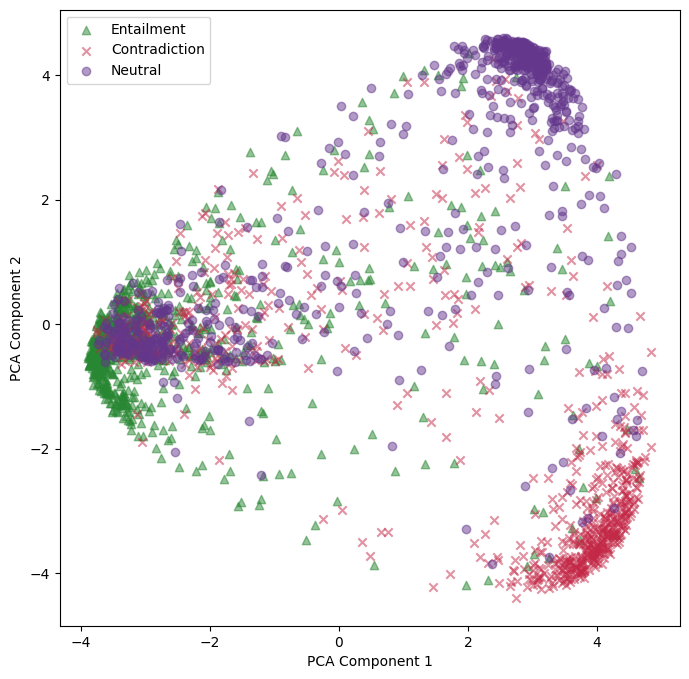

In [64]:
import numpy as np
import os

PLT_COLORS = ["#64378C", "#C42847", "#288732", "#E7F9A9", "#2DD881"]

def plot_results(test_predictions, test_dataset):
    predictions = test_predictions[0]
    ground_truth = test_predictions[1]
    test_results = test_predictions[2]

    # Perform PCA and plot the embeddings of the results
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    embeddings = predictions

    pca_embeddings = pca.fit_transform(embeddings)

    entilements    = []
    contradictions = []
    neutrals       = []

    for i, label in enumerate(ground_truth):
        if label == 0:
            entilements.append(pca_embeddings[i])
        elif label == 1:
            contradictions.append(pca_embeddings[i])
        else:
            neutrals.append(pca_embeddings[i])

    entilements    = np.array(entilements)
    contradictions = np.array(contradictions)
    neutrals       = np.array(neutrals)

    if not os.path.exists('./output'):
        os.makedirs('./output')

    plt.figure(figsize=(8, 8))
    plt.scatter(entilements[:, 0], entilements[:, 1], color=PLT_COLORS[2], label='Entailment', alpha=0.5, marker='^')
    plt.scatter(contradictions[:, 0], contradictions[:, 1], color=PLT_COLORS[1], label='Contradiction', alpha=0.5, marker='x')
    plt.scatter(neutrals[:, 0], neutrals[:, 1], color=PLT_COLORS[0], label='Neutral', alpha=0.5, marker='o')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.savefig(f'./output/{CURRENT_MODEL}-pca.pdf')
    plt.show()

    accuracy = test_results['test_accuracy']
    macro_test_results = test_results['test_macro avg']
    f1_score = macro_test_results['f1-score']
    runtime = test_results['test_runtime']

    with open(f'./output/{CURRENT_MODEL}-results.txt', 'w') as f:
        f.write(f'Accuracy: {accuracy}\n')
        f.write(f'F1 Score: {f1_score}\n')
        f.write(f'Runtime: {runtime}\n')


plot_results(test_predictions, test_dataset)

In [61]:
test_predictions[2]

{'test_loss': 1.3063030242919922,
 'test_0': {'precision': 0.5663643858202803,
  'recall': 0.8910505836575876,
  'f1-score': 0.6925403225806451,
  'support': 771.0},
 'test_1': {'precision': 0.8618677042801557,
  'recall': 0.5768229166666666,
  'f1-score': 0.6911076443057722,
  'support': 768.0},
 'test_2': {'precision': 0.7818853974121996,
  'recall': 0.5802469135802469,
  'f1-score': 0.6661417322834645,
  'support': 729.0},
 'test_accuracy': 0.6847442680776014,
 'test_macro avg': {'precision': 0.7367058291708785,
  'recall': 0.6827068046348338,
  'f1-score': 0.6832632330566274,
  'support': 2268.0},
 'test_weighted avg': {'precision': 0.735703612463884,
  'recall': 0.6847442680776014,
  'f1-score': 0.6835699216804039,
  'support': 2268.0},
 'test_runtime': 12.415,
 'test_samples_per_second': 182.683,
 'test_steps_per_second': 22.876}